In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
%matplotlib inline

In [3]:
sns.set_style('darkgrid')

In [107]:
conn = psycopg2.connect("dbname='FVSOut' user='postgres' host='localhost' port='5433'") # password in pgpass file
SQL = '''
SELECT parcel.parcelid, SUM(acres) AS acres, SUM(baucore) AS core_bau, SUM(fsccore) AS core_fsc,
    SUM(nonrip_fsc) AS nonrip_fsc, SUM(nonrip_bau) AS nonrip_bau, stateid AS state
FROM parcel, state
WHERE parcel.standid = state.standid
GROUP BY parcel.parcelid, state.stateid;
'''
# read the query into a pandas dataframe
parcels = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [108]:
parcels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 7 columns):
parcelid      67 non-null object
acres         67 non-null float64
core_bau      67 non-null float64
core_fsc      67 non-null float64
nonrip_fsc    67 non-null float64
nonrip_bau    67 non-null float64
state         67 non-null object
dtypes: float64(5), object(2)
memory usage: 3.7+ KB


In [109]:
parcels.head()

,parcelid,acres,core_bau,core_fsc,nonrip_fsc,nonrip_bau,state
0,40,632.180,10.870000,20.820000,611.200000,607.990001,OR
1,33,631.539,11.067251,47.520000,583.970000,594.610000,WA
2,13,159.459,0.000000,0.000000,159.458994,159.458994,OR
3,11,114.400,0.000000,8.378858,105.990000,114.400000,OR
4,24,614.889,20.015378,84.360365,530.429999,504.610000,WA


In [110]:
parcels['rip_fsc'] = parcels.acres - parcels.nonrip_fsc
parcels['rip_bau'] = parcels.acres - parcels.nonrip_bau
parcels['pctrip_fsc'] = parcels.rip_fsc / parcels.acres
parcels['pctrip_bau'] = parcels.rip_bau / parcels.acres
parcels['pctcore_fsc'] = parcels.core_fsc / parcels.acres
parcels['pctcore_bau'] = parcels.core_bau / parcels.acres

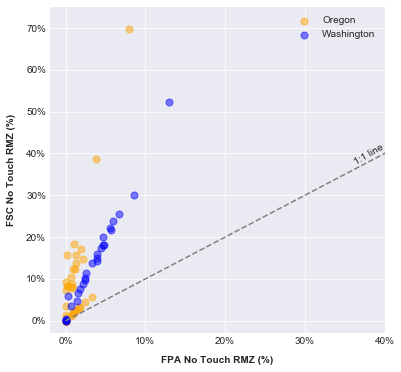

In [192]:
fig, ax = plt.subplots(1, figsize=(6,6))
parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=50, alpha=0.5,
                                                ax=ax, label='Oregon', color='orange', )
parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctcore_bau', y='pctcore_fsc', s=50, alpha=0.5,
                                                ax=ax, label='Washington', color='blue')
#parcels.loc[parcels.state == 'OR'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=50,
#                                                ax=ax, label='Oregon', c='none', edgecolors='orange')
#parcels.loc[parcels.state == 'WA'].plot.scatter(x='pctrip_bau', y='pctrip_fsc', s=50, 
#                                                ax=ax, label='Washington', c='none', edgecolors='blue')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='gray', linestyle='--')
ax.set_xlim(-0.02,0.2)
ax.set_ylim(-0.03,0.75)
ax.set_xticks(np.arange(0,0.5,0.1))
ax.set_yticks(np.arange(0,0.8,0.1))
ax.set_ylabel('FSC No Touch RMZ (%)', weight='bold', labelpad=10)
ax.set_xlabel('FPA No Touch RMZ (%)', weight='bold', labelpad=10)
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.xaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
plt.text(0.36,0.41, '1:1 line', rotation=30)
plt.legend(loc='upper right')
plt.savefig('FVSvFPA_RMZcore.png');

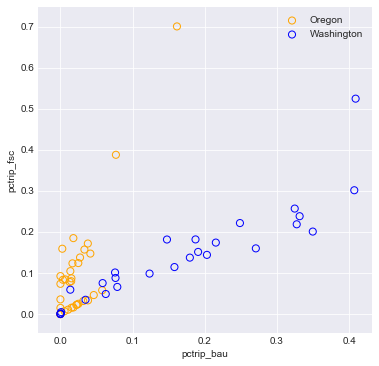

In [190]:
fig, ax = plt.subplots(1, figsize=(6,6))


In [4]:
data = pd.read_csv('C:/Users/ddiaz/Desktop/rxAll.csv')

In [5]:
data.head()

,parcel,year,aboveground_total_live,belowground_live,standing_dead,products,npv_total,cumulative_mbf,acres,carbon,cpaE,wpaE,rx
0,1,2014,37.473597,8.908928,0.206641,84.117597,29165.020024,6.380363,578.49,46.589166,170.982240,308.711581,BAU
1,1,2019,19.646871,3.534403,0.086442,81.200091,32802.879949,6.952494,578.41,23.267715,85.392515,298.004336,BAU
2,1,2024,24.928333,5.572933,0.231288,65.642262,32546.576355,6.024604,579.21,30.732554,112.788475,240.907101,BAU
3,1,2029,41.636070,10.150793,0.389880,56.223565,32409.321455,5.917257,577.98,52.176742,191.488645,206.340484,BAU
4,1,2034,79.892279,17.530288,0.563104,51.412277,32377.274581,6.259901,579.27,97.985671,359.607411,188.683058,BAU


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5360 entries, 0 to 5359
Data columns (total 13 columns):
parcel                    5360 non-null int64
year                      5360 non-null int64
aboveground_total_live    5360 non-null float64
belowground_live          5360 non-null float64
standing_dead             5360 non-null float64
products                  5360 non-null float64
npv_total                 5360 non-null float64
cumulative_mbf            5360 non-null float64
acres                     5360 non-null float64
carbon                    5360 non-null float64
cpaE                      5360 non-null float64
wpaE                      5360 non-null float64
rx                        5360 non-null object
dtypes: float64(10), int64(2), object(1)
memory usage: 544.5+ KB


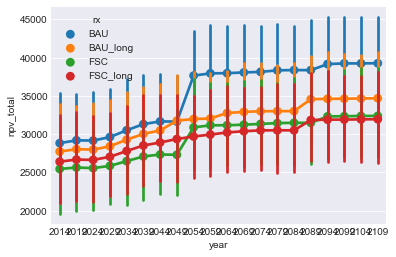

In [20]:
ax = sns.pointplot(data=data, hue='rx', x='year', y='npv_total', units='parcel')
plt.savefig('npv_v1.png')

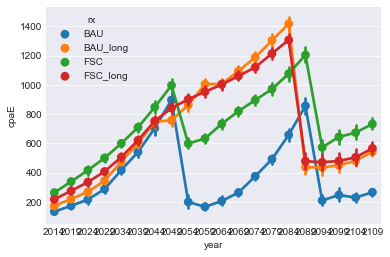

In [7]:
ax = sns.pointplot(data=data, hue='rx', x='year', y='cpaE', units='parcel')
plt.savefig('forestcarbon_v1.png')

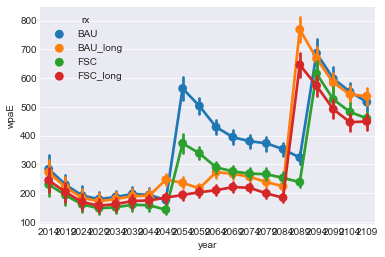

In [8]:
ax = sns.pointplot(data=data, hue='rx', x='year', y='wpaE', units='parcel')
plt.savefig('woodcarbon_v1.png')

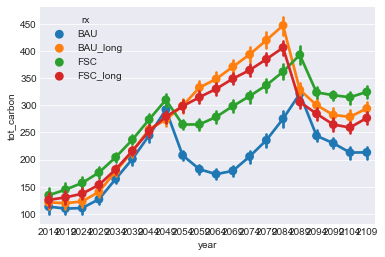

In [9]:
data['tot_carbon'] = data.carbon + data.products
ax = sns.pointplot(data=data, hue='rx', x='year', y='tot_carbon', units='parcel')
plt.savefig('totcarbon_v1.png')

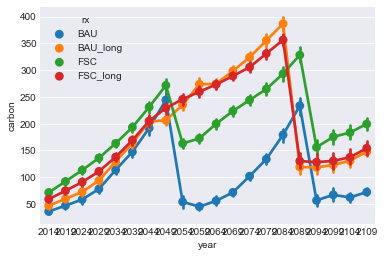

In [21]:
ax = sns.pointplot(data=data, hue='rx', x='year', y='carbon', units='parcel')
plt.savefig('carbon_v1.png')

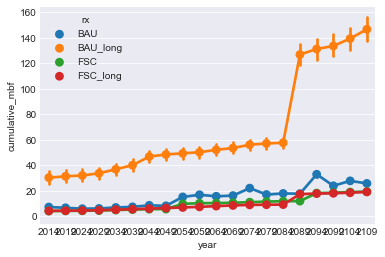

In [24]:
ax = sns.pointplot(data=data, hue='rx', x='year', y='cumulative_mbf', units='parcel')
plt.savefig('yield_v1.png')

### Inspect outputs by Rx (not adjusted by area of each property)

In [ ]:
grouped_merchbdft = FVSOut[['mgmtid', 'standid', 'mrch_boardfoot_volume']].groupby(['mgmtid', 'standid']).sum() 
grouped_sumrbdft = FVSOut[['mgmtid', 'standid', 'rbdft']].groupby(['mgmtid', 'standid']).sum()
grouped_endbdft = FVSOut[['standid', 'mgmtid', 'bdft']].loc[FVSOut.year==2104].groupby(['mgmtid', 'standid']).sum()
grouped_avgcarbon = FVSOut[['mgmtid', 'standid', 'allcarbon']].groupby(['mgmtid', 'standid']).mean()
grouped_rev = FVSOut[['standid', 'mgmtid', 'undiscounted_net', 'pnv']].loc[FVSOut.year==2104].groupby(['mgmtid', 'standid']).sum()
regrouped = pd.concat([grouped_merchbdft, grouped_sumrbdft, grouped_endbdft, grouped_avgcarbon, grouped_rev], axis=1).sort_index()
regrouped.head()

In [ ]:
regrouped['tot_bdft'] = regrouped.rbdft + regrouped.bdft

In [ ]:
baseline = regrouped.xs('Rx2', level='mgmtid', drop_level=True)
baseline.head()

In [ ]:
diff = regrouped - baseline

In [ ]:
fig, ax = plt.subplots(figsize=(14,10))
ax = sns.violinplot(y=diff.index.get_level_values(0), x=diff.rbdft, orient='h', split=True, scale='width')
ax.set_title('Harvested boardfeet over 100 years + Standing bdft at end of 100yrs, relative to FSC-Short')
#ax.set_xlim(-20000, 1000)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)

### Get info about property ages and areas

In [ ]:
conn = psycopg2.connect("dbname='FVSIn' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT stand_id as standid, age, site_index, variant
FROM stand_init;
'''
# read the query into a pandas dataframe
stand_atts = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [ ]:
conn = psycopg2.connect("dbname='FVSOut20170824' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT parcel, standid, matrix.type, non_rip, core, matrix.inner, matrix.outer, fsc_grow, fsc, total as total_acres
FROM matrix;
'''
# read the query into a pandas dataframe
parcel_atts = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [ ]:
parcel_atts = parcel_atts.set_index('standid')
parcel_atts.head()

In [ ]:
parcel_states = pd.read_csv('C:/GitHub/FSC_Case_Studies/Data/parcel_state.csv', index_col='parcel')

In [ ]:
parcel_states.head()

In [ ]:
def name_state(state_code):
    if state_code == 41:
        return 'OR'
    elif state_code == 53:
        return 'WA'

In [ ]:
parcel_states['state_name'] = parcel_states.state.apply(name_state)

In [ ]:
acres = parcel_atts[['total_acres']]
stand_atts = stand_atts.set_index('standid')
stand_atts = pd.concat([stand_atts, acres], axis=1)
stand_atts.index.name = 'standid'

In [ ]:
stand_atts.info()

In [ ]:
stand_atts['weighted_age'] = stand_atts.total_acres * stand_atts.age
stand_atts['weighted_site_index'] = stand_atts.total_acres * stand_atts.site_index
parcel_atts.rename(columns={'type': 'origin'}, inplace=True)

In [ ]:
stand_atts.head()

In [ ]:
temp = pd.concat([parcel_atts, stand_atts.drop('total_acres', axis=1)],axis=1)
weighted = temp[['origin', 'parcel', 'total_acres', 'weighted_age', 'weighted_site_index']].groupby(['parcel', 'origin']).sum()
#weighted.info()
weighted['age'] = weighted.weighted_age/weighted.total_acres
weighted['site_index'] = weighted.weighted_site_index/weighted.total_acres

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.distplot(weighted.age, bins=range(0,140,10), norm_hist=False, kde=False, hist_kws={'alpha':0.9, 'color':'orange', 'edgecolor':'black', 'linewidth':1.2})
ax.set_xlabel('Average Property Age (area-weighted)', fontsize=20, labelpad=15, fontname='Georgia', style='italic')
ax.set_ylabel('# of Properties', fontsize=20, labelpad=10, fontname='Georgia', style='italic')
plt.yticks(range(2,20, 2))
plt.xticks(range(0,140,10))
ax.set_xlim(0, 140)
ax.set_ylim(0, 20)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(16)
plt.axvline(x=weighted.age.median(), ymin=0, ymax=20, color='black', linestyle=':', linewidth=1.5)
plt.text(weighted.age.median()-0.5,21.75,'Median',rotation=90, fontsize=12)
fig.savefig('C:/Users/ddiaz/Desktop/PropertyAges.png')
plt.show()

## Making graphs of scenarios for all properties

In [ ]:
parcel_id = [parcel for parcel in pd.unique(parcel_atts.parcel)]
rxs = ['FPA-SHORT', 'FSC-SHORT', 'FPA-LONG', 'FSC-LONG', 'GROW-ONLY']
years = [yr for yr in range(2014,2114,5)]
to_combine = [parcel_id, rxs, years]
graph_df = pd.DataFrame(list(itertools.product(*to_combine)), columns=['parcel', 'rx', 'year'])
graph_df['mrch_boardfoot_volume'] = np.nan
graph_df['allcarbon'] = np.nan
graph_df['pnv'] = np.nan
graph_df['rbdft'] = np.nan
graph_df['undiscounted_net'] = np.nan
graph_df = graph_df.set_index(['rx', 'parcel', 'year']).sort_index()

# for "leveling the playing field" scenarios where we hold buffers constant across scenarios
FPA_bufs = graph_df.copy()
FSC_bufs = graph_df.copy()

In [ ]:
graph_df.head()

In [ ]:
parcels = parcel_atts.reset_index().set_index('standid')
fvs = parcels.join(FVSOut.set_index(['standid', 'year']))
fvs = fvs.reset_index().set_index(['parcel', 'mgmtid', 'standid', 'year']).sort_index()

In [ ]:
fvs.head()

### Expand per-acre outputs to property sizes using separate FPA and FSC buffers
This follows FPA buffers for FPA scenarios, and FSC buffers for FSC scenarios.

In [ ]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)
    
# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    graph_df.update(temp)

# Add total_acres and % riparian cover
graph_df = graph_df.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

graph_df['cum_MBF_acre'] = graph_df.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / graph_df.total_acres
graph_df['tco2e_acre'] = graph_df.allcarbon *44/12 / graph_df.total_acres
graph_df['npv_acre'] = graph_df.pnv / graph_df.total_acres
graph_df['undisc_net_acre'] = graph_df.undiscounted_net / graph_df.total_acres
graph_df['cum_rMBF_acre'] = graph_df.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / graph_df.total_acres
graph_df['pct_fscgrow'] = graph_df.fsc_grow / graph_df.total_acres


# add state_names for each parcel, append state_name to multi-level index of dataframe
graph_df = graph_df.join(parcel_states.state_name)
graph_df = graph_df.set_index('state_name', append=True)

# take a peek
graph_df.head()

### Graph attributes over time (hurricane-style graphs)

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))
attribute = 'tco2e_acre'
scenario = 'FSC-LONG'
base_scenario = 'FPA-SHORT'
baseline = graph_df.xs(base_scenario, level=0)
diff = graph_df.xs(scenario, level=0) - baseline
diff = diff.reset_index()
years = np.array(pd.unique(diff.year))
mean = diff.groupby('year').mean()[attribute]
pct25 = diff.groupby('year').quantile(.25)[attribute]
pct75 = diff.groupby('year').quantile(.75)[attribute]
minimum = diff.groupby('year').min()[attribute]
maximum = diff.groupby('year').max()[attribute]

ax.plot(years,mean , lw=2, color='blue')
ax.fill_between(years, pct25, pct75, facecolor='blue', alpha=0.20)
ax.fill_between(years, minimum, maximum, facecolor='blue', alpha=0.15)

#ax = sns.tsplot(data=rx4, time='year', unit='parcel', value='tco2e_acre', err_style='unit_traces')
#ax = sns.tsplot(data=rx4, time='year', unit='parcel', value='tco2e_acre', err_style='range_band', n_boot=0)
ax.set_ylim(-250, 450)
ax.set_xlim(years.min(), years.max())
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.75)
ax.text(x=years.min()-2, y=400, s='$tCO_2e/ac$', fontsize=10, fontname='Georgia', verticalalignment='center', style='italic')
ax.text(x=2107, y=390, s=scenario, fontsize=24, fontname='Agenda', weight='semibold', horizontalalignment='right', verticalalignment='center')
ax.text(x=years[-1]+1, y=minimum.iloc[-1], s='min', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=pct25.iloc[-1], s='25%', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=pct75.iloc[-1], s='75%', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=maximum.iloc[-1], s='max', fontname='Georgia', style='italic', fontsize=10)
ax.text(x=years[-1]+1, y=mean.iloc[-1], s='mean', fontname='Georgia', style='italic', fontsize=10)
plt.show()

### Scatter plot of attributes at end of simulation

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, figsize=(8,7))
state = 'WA'
fullname = 'Washington' if state == 'WA' else 'Oregon'
temp_df = graph_df.loc[graph_df.index.get_level_values(3) == state]
BAU_cumMBF = temp_df.loc['FPA-SHORT'].xs(2109, level=(1)).cum_MBF_acre
BAU_avgC = temp_df.loc['FPA-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_cumMBF = temp_df.loc['FSC-SHORT'].xs(2109, level=(1)).cum_MBF_acre
fsc_short_avgC = temp_df.loc['FSC-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_long_cumMBF = temp_df.loc['FSC-LONG'].xs(2109, level=(1)).cum_MBF_acre
fsc_long_avgC = temp_df.loc['FSC-LONG'].tco2e_acre.groupby(level='parcel').mean()
fpa_long_cumMBF = temp_df.loc['FPA-LONG'].xs(2109, level=(1)).cum_MBF_acre
fpa_long_avgC = temp_df.loc['FPA-LONG'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_x = (fsc_short_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fsc_short_y = (fsc_short_avgC - BAU_avgC)/BAU_avgC * 100
fsc_long_x = (fsc_long_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fsc_long_y = (fsc_long_avgC - BAU_avgC)/BAU_avgC * 100
fpa_long_x = (fpa_long_cumMBF - BAU_cumMBF)/BAU_cumMBF * 100
fpa_long_y = (fpa_long_avgC - BAU_avgC)/BAU_avgC * 100
marker_size = temp_df.pct_fscgrow.groupby('parcel').mean()

# Scatter of carbon and timber for all properties
ax.scatter(fsc_short_x, fsc_short_y, color='orange', alpha=0.5, s=25+marker_size*900, label='FSC-SHORT')
ax.scatter(fsc_long_x, fsc_long_y, color='blue', alpha=0.4, s=25+marker_size*900, label='FSC-LONG')

# FPA-LONG scenario
ax.scatter(fpa_long_x, fpa_long_y, color='green', alpha=0.3, s=25+marker_size*900, label='FPA-LONG')
ax.scatter(fpa_long_x.median(), fpa_long_y.median(), color='green', marker='X', s=200, edgecolor='black')

# Medians of all properties
ax.scatter(fsc_short_x.median(), fsc_short_y.median(), color='orange', marker='X', s=200, edgecolor='black')
ax.scatter(fsc_long_x.median(), fsc_long_y.median(), color='blue', marker='X', s=200, edgecolor='black')
# for legend
ax.scatter(-10000, -10000, color='gray', marker='X', s=200, edgecolor='gray', label='Median of each group')


# Styling
ax.axhline(y=0, color='black', linewidth=1.25)
ax.axvline(x=0, color='black', linewidth=1.25)
ax.set_ylim(-10, 100)
ax.set_xlim(-75, 50)
ax.set_ylabel('Carbon storage vs. FPA-SHORT', labelpad=10, fontsize=15, fontname='Agenda', style='italic')
ax.set_xlabel('Timber yield vs. FPA-SHORT', labelpad=15, fontsize=15, fontname='Agenda', style='italic')

plt.yticks([x for x in range(0,125,25)], fontsize=14, fontname='Agenda', weight='book')
plt.xticks([x for x in range(-75,75,25)], fontsize=14, fontname='Agenda', weight='book')
ax.text(x=-71, y=92, s=fullname, fontsize=32, fontname='Agenda', weight='semibold', horizontalalignment='left', verticalalignment='center')
tick = ticker.StrMethodFormatter('{x:+}%')
ax.xaxis.set_major_formatter(tick)
ax.yaxis.set_major_formatter(tick)
plt.legend(loc='upper left', bbox_to_anchor=(0.02,0.90), fontsize=12, markerscale=0.7)
plt.savefig('C:/Users/ddiaz/Desktop/FSCscatter_OR_wFPAlong.png')
plt.show()

### Expand per-acre outputs to property sizes using FPA buffers
This follows FPA buffers for all scenarios (both FPA and FSC).

In [ ]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
#     fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
#     fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FPA_bufs.update(temp)

# Add total_acres and % riparian cover
FPA_bufs = FPA_bufs.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

FPA_bufs['cum_MBF_acre'] = FPA_bufs.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FPA_bufs.total_acres
FPA_bufs['tco2e_acre'] = FPA_bufs.allcarbon *44/12 / FPA_bufs.total_acres
FPA_bufs['npv_acre'] = FPA_bufs.pnv / FPA_bufs.total_acres
FPA_bufs['undisc_net_acre'] = FPA_bufs.undiscounted_net / FPA_bufs.total_acres
FPA_bufs['cum_rMBF_acre'] = FPA_bufs.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FPA_bufs.total_acres
FPA_bufs['pct_fscgrow'] = FPA_bufs.fsc_grow / FPA_bufs.total_acres

# add state_names for each parcel, append state_name to multi-level index of dataframe
FPA_bufs = FPA_bufs.join(parcel_states.state_name)
FPA_bufs = FPA_bufs.set_index('state_name', append=True)

# take a peek
FPA_bufs.head()

### Estimate the relative change in attributes when all scenarios use FPA buffers.

In [ ]:
new_base_scenario = 'FPA-SHORT'
compare_scenario = 'FSC-SHORT'
new_baseline = FPA_bufs.xs(new_base_scenario, level=0)
new_scenario = FPA_bufs.xs(compare_scenario, level=0)
new_diff = (new_scenario - new_baseline)/new_baseline

# use the final year's cumulative value of npv, timber yield to identify median change for parcels vs. FPA-SHORT
print(compare_scenario, 'with FPA buffers')
print(new_diff[['cum_MBF_acre', 'npv_acre']].xs(new_diff.index.get_level_values(1).max(), level=1, drop_level=False).groupby(level=2).median())
# use the average over all years of scenarios to get median change in carbon storage
print(compare_scenario, 'FPA buffers')
print(new_diff['tco2e_acre'].groupby(level=[0,2]).mean().groupby(level=1).median())

### Expand per-acre outputs to property sizes using FSC buffers
This follows FSC buffers for all scenarios (both FPA and FSC).

In [ ]:
# rx2 FPA-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
#     core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     inner = fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx2I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     outer = fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx2O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     non_rip = fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx2', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx3 FSC-SHORT
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx3', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-SHORT'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx4 FSC-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx4', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FSC-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx5 FPA-LONG
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    fsc_grow = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc_grow * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    fsc = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().fsc * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    total = pd.concat([fsc_grow, fsc])
#     core = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().core * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     inner = fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum().inner * fvs.xs('Rx5I', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     outer = fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum().outer * fvs.xs('Rx5O', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     non_rip = fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum().non_rip * fvs.xs('Rx5', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
#     total = pd.concat([core, inner, outer, non_rip])
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'FPA-LONG'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)

# rx1 GROW-ONLY
for attribute in ['allcarbon', 'pnv', 'mrch_boardfoot_volume', 'rbdft', 'undiscounted_net']:
    total = fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum().total_acres * fvs.xs('Rx1', level=1).groupby(['parcel', 'standid', 'year']).sum()[attribute]
    by_parcel = total.groupby(level=['parcel', 'year']).sum()
    temp = by_parcel.reset_index()
    temp['rx'] = 'GROW-ONLY'
    temp = temp.set_index(['rx', 'parcel', 'year'])
    temp = temp.rename(columns={0:attribute})
    FSC_bufs.update(temp)
    
# Add total_acres and % riparian cover
FSC_bufs = FSC_bufs.join(parcel_atts[['total_acres', 'fsc_grow', 'parcel']].groupby('parcel').sum())

FSC_bufs['cum_MBF_acre'] = FSC_bufs.mrch_boardfoot_volume.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FSC_bufs.total_acres
FSC_bufs['tco2e_acre'] = FSC_bufs.allcarbon *44/12 / FSC_bufs.total_acres
FSC_bufs['npv_acre'] = FSC_bufs.pnv / FSC_bufs.total_acres
FSC_bufs['undisc_net_acre'] = FSC_bufs.undiscounted_net / FSC_bufs.total_acres
FSC_bufs['cum_rMBF_acre'] = FSC_bufs.rbdft.groupby(level=['rx', 'parcel']).cumsum() / 1000 / FSC_bufs.total_acres
FSC_bufs['pct_fscgrow'] = FSC_bufs.fsc_grow / FSC_bufs.total_acres

# add state_names for each parcel, append state_name to multi-level index of dataframe
FSC_bufs = FSC_bufs.join(parcel_states.state_name)
FSC_bufs = FSC_bufs.set_index('state_name', append=True)

# take a peek
FSC_bufs.head()

In [ ]:
new_base_scenario = 'FPA-SHORT'
compare_scenario = 'FPA-LONG'
new_baseline = FPA_bufs.xs(new_base_scenario, level=0)
new_scenario = FPA_bufs.xs(compare_scenario, level=0)
new_diff = (new_scenario - new_baseline)/new_baseline

# use the final year's cumulative value of npv, timber yield to identify median change for parcels vs. FPA-SHORT
print(compare_scenario, 'with FSC buffers' )
print(new_diff[['cum_MBF_acre', 'npv_acre']].xs(new_diff.index.get_level_values(1).max(), level=1, drop_level=False).groupby(level=2).median())
# use the average over all years of scenarios to get median change in carbon storage
print(compare_scenario, 'FPA buffers')
print(new_diff['tco2e_acre'].groupby(level=[0,2]).mean().groupby(level=1).median())

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, figsize=(8,7))
state = 'OR'
fullname = 'Washington' if state == 'WA' else 'Oregon'
temp_df = graph_df.loc[graph_df.index.get_level_values(3) == state]
BAU_cumMBF = temp_df.loc['FPA-SHORT'].xs(2109, level=(1)).cum_MBF_acre
BAU_avgC = temp_df.loc['FPA-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_short_cumMBF = temp_df.loc['FSC-SHORT'].xs(2109, level=(1)).cum_MBF_acre
fsc_short_avgC = temp_df.loc['FSC-SHORT'].tco2e_acre.groupby(level='parcel').mean()
fsc_long_cumMBF = temp_df.loc['FSC-LONG'].xs(2109, level=(1)).cum_MBF_acre
fsc_long_avgC = temp_df.loc['FSC-LONG'].tco2e_acre.groupby(level='parcel').mean()
fpa_long_cumMBF = temp_df.loc['FPA-LONG'].xs(2109, level=(1)).cum_MBF_acre
fpa_long_avgC = temp_df.loc['FPA-LONG'].tco2e_acre.groupby(level='parcel').mean()
grow_only_cumMBF = temp_df.loc['GROW-ONLY'].xs(2109, level=(1)).cum_MBF_acre
grow_only_avgC = temp_df.loc['GROW-ONLY'].tco2e_acre.groupby(level='parcel').mean()
# fsc_short_x = fsc_short_cumMBF
# fsc_short_y = fsc_short_avgC
# fsc_long_x = fsc_long_cumMBF
# fsc_long_y = fsc_long_avgC
# fpa_long_x = fpa_long_cumMBF
# fpa_long_y = fpa_long_avgC
# grow_only_x = grow_only_cumMBF
# grow_only_y = grow_only_avgC
marker_size = temp_df.pct_fscgrow.groupby('parcel').mean()

# Scatter of carbon and timber for all properties
ax.scatter(BAU_cumMBF, BAU_avgC, edgecolor='#7fc97f', alpha=0.75, s=80, label='FPA-SHORT')
ax.scatter(fsc_short_cumMBF, fsc_short_avgC, color='#beaed4', alpha=0.85, edgecolor='gray', s=80, label='FSC-SHORT')
ax.scatter(fsc_long_cumMBF, fsc_long_avgC, color='#ffff99', alpha=0.75, edgecolor='gray', s=80, label='FSC-LONG')
ax.scatter(fpa_long_cumMBF, fpa_long_avgC, color='#fdc086', alpha=0.75, edgecolor='gray', s=80, label='FPA-LONG')
ax.scatter(grow_only_cumMBF, grow_only_avgC, color='darkgray', alpha=0.35, edgecolor='gray', s=80, label='GROW-ONLY', zorder=2)


# Medians of all properties
# ax.scatter(BAU_cumMBF.median(), BAU_avgC.median(), color='#7fc97f', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fsc_long_cumMBF.median(), fsc_long_avgC.median(), color='#beaed4', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fsc_short_cumMBF.median(), fsc_short_avgC.median(), color='#ffff99', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(fpa_long_cumMBF.median(), fpa_long_avgC.median(), color='#fdc086', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(grow_only_cumMBF.median(), grow_only_avgC.median(), color='darkgray', marker='X', s=100, edgecolor='black', zorder=3)
# ax.scatter(-10000, -10000, color='gray', marker='X', s=100, edgecolor='gray', label='Median of each group') # for legend

# Styling
ax.axhline(y=0, color='black', linewidth=1, linestyle=':', zorder=1)
ax.axvline(x=0, color='black', linewidth=1, linestyle=':', zorder=1)
ax.set_ylim(-50, 1000)
ax.set_xlim(-10, 200)
ax.set_ylabel('Average carbon storage (tCO2e/ac)', labelpad=10, fontsize=15, fontname='Agenda', style='italic')
ax.set_xlabel('Cumulative timber yield (MBF/ac)', labelpad=15, fontsize=15, fontname='Agenda', style='italic')

plt.yticks([x for x in range(0,1001,250)], fontsize=14, fontname='Agenda', weight='book')
plt.xticks([x for x in range(0,201,50)], fontsize=14, fontname='Agenda', weight='book')
ax.text(x=190, y=920, s=fullname, fontsize=32, fontname='Agenda', weight='semibold', horizontalalignment='right', verticalalignment='center')
#tick = ticker.StrMethodFormatter('{x:+}')
#ax.xaxis.set_major_formatter(tick)
#ax.yaxis.set_major_formatter(tick)
plt.legend(loc='upper right', bbox_to_anchor=(0.99,0.89), fontsize=12, markerscale=0.7)
plt.savefig('C:/Users/ddiaz/Desktop/FSCscatter_WA-allscenarios.png')
plt.show()